In [ ]:
import numpy as np
import torch.nn as nn
import torch as tr
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# agent_gpu
def cross_entropy_with_soft_label(pred, targ):
    return -(targ * pred.log()).sum(dim=-1).mean()

class SimpleAgent():
    def __init__(self, lr = 0.2, state_shape = (11,11,4)): # state: 2d grid is 11*11 
        # It quantifies how much importance we give for future rewards. 
        # It’s also handy to approximate the noise in future rewards. 
        # Gamma varies from 0 to 1. 
        # If Gamma is closer to zero, the agent will tend to consider only immediate rewards. 
        # If Gamma is closer to one, the agent will consider future rewards with greater weight, willing to delay the reward.
        # Q[s, a] = Q[s, a] + alpha*(R + gamma*Max[Q(s’, A)] - Q[s, a]) -  formula to calculate the Q[state, action] - seen as brain of agents
        # s - states, a - action, alpha - learning rate gamma: discount factor, epsilon: exploration rate
        # https://towardsdatascience.com/practical-reinforcement-learning-02-getting-started-with-q-learning-582f63e4acd9 
        self.gamma = 0.99 # discount factor
        self.value = ConvQNet(state_shape).cuda()
        self.policy = ConvQNet(state_shape).cuda()
        self.optimizer = tr.optim.Adam(self.policy.parameters(), lr=lr)
        self.memory = []
        self.states = []
        self.prs = []
        self.acts = []
        self.loss = []
        self.done = []
        self.ntrained = 0
        self.hidden_state = (tr.zeros(64, device='cuda'),
                             tr.zeros(64, device='cuda'))
        
    def reset(self):
        self.states = []
        self.prs = []
        self.acts = []
        self.done = []
        self.hidden_state = (tr.zeros(64, device='cuda'),
                             tr.zeros(64, device='cuda'))
        self.value.load_state_dict(self.policy.state_dict())
        self.value.eval()
    
    def act(self, states, definitive = False):
        self.states.append(states)
        prs = self.policy.forward(states)
        if definitive:
            a = prs.max(1)[1].view([-1, 1]).detach()
        else:
            a = tr.multinomial(tr.softmax(prs, 1), 1)
        self.prs.append(prs.gather(1, a))
        self.acts.append(a)
        return a
      
    def loadnet(self, state_dict):
        self.policy.load_state_dict(state_dict)
        self.value.load_state_dict(state_dict)
    
    def train(self, rewards):
        # print(self.value.forward(self.states.pop()).max(1)[0].detach().shape)
        # expected_state_action_value = self.value.forward(self.states.pop()).max(1)[0].detach()*self.gamma + rewards
        expvalues = self.value.forward(self.states.pop())
        expected_state_action_value = (expvalues * tr.softmax(expvalues, 1)).mean(1).detach()*self.gamma + rewards
        state_action_value = self.prs.pop() # state action value
        
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_value.view(-1), expected_state_action_value)
        self.loss.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        # self.value.load_state_dict(self.policy.state_dict())
        # self.ntrained += 1
    
  

In [ ]:
# modified agent
class StepAgent():
    def __init__(self, lr = 0.2, state_shape = (11,11,4)):
        self.gamma = 0.90
        # self.value = SimpleQNet(state_shape).cuda()
        self.policy = DeepQNet(state_shape).cuda()
        self.optimizer = tr.optim.SGD(self.policy.parameters(), lr=lr)
        self.states = []
        self.last_action_value = None
        # self.acts = []
        self.rewards = []
        # self.done = []
        self.loss = []
        self.ntrained = 0
        # self.hidden_state = (tr.zeros(64, device='cuda'),
        #                      tr.zeros(64, device='cuda'))
        
    def reset(self):
        # self.states = []
        self.last_action_value = None
        # self.acts = []
        # self.rewards = []
        # self.done = []
        # self.hidden_state = (tr.zeros(64, device='cuda'),
        #                      tr.zeros(64, device='cuda'))
        # self.value.load_state_dict(self.policy.state_dict())
        # self.value.eval()
    
    def act(self, states, definitive = False):
        
        prs = self.policy(states)
        if definitive:
            a = prs.max(1)[1].view([-1, 1]).detach()
        else:
            a = tr.multinomial(tr.softmax(2*prs[:,1:], 1), 1).detach()
            a += 1
        self.last_action_value = prs.gather(1, a)
        # self.acts.append(a)
        return a
      
    def reward(self, rewards, states):
        self.rewards.append(rewards)
        self.states.append(states)
        
    def loadnet(self, state_dict):
        self.policy.load_state_dict(state_dict)
        #self.value.load_state_dict(state_dict)
    
    def train(self):

        # expvalues = self.value.forward(self.states[-1])
        # expected_state_action_value = (expvalues * tr.softmax(expvalues, 1)).sum(1).detach()*self.gamma + self.rewards[-1]
        # state_action_value = self.prs.pop() # state action value
        next_prs = self.policy(self.states[-1]).detach()
        next_value = (next_prs[:,1:] * tr.softmax(next_prs[:,1:], 1)).sum(1)*self.gamma + self.rewards[-1]
        
        criterion = nn.MSELoss()
        loss = criterion(self.last_action_value.view(-1), next_value)
        self.loss.append(loss.item())
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

In [ ]:
# simple q net
class SimpleQNet(nn.Module): # if we view it as function Q
    def __init__(self, state_shape = (16,16,4)):
        super().__init__()
        '''
        self.conv1 = ResNetBlock(state_shape[-1], 4, 1)
        self.conv2 = ResNetBlock(4, 8, stride = 1, kernel_size = 5, padding = 2)
        self.conv3 = ResNetBlock(8, 16, stride = 1, kernel_size = 7, padding = 3)
        self.conv4 = ResNetBlock(16, 32, stride = 1, kernel_size = 9, padding = 4)
        self.conv5 = ResNetBlock(32, 32, stride = 1, kernel_size = 11, padding = 5)
        '''
        self.conv1 = nn.Conv2d(state_shape[-1], 16, stride = 1, kernel_size = 3, padding = 1, bias = False)
        nn.init.uniform_(self.conv1.weight, a = -0.01, b = 0.01)
        self.conv2 = nn.Conv2d(16, 32, stride = 1, kernel_size = 3, padding = 1, bias = False)
        nn.init.uniform_(self.conv2.weight, a = -0.01, b = 0.01)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=False)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(11) # world size
        self.fc = nn.Linear(32, 5, bias = False)
        nn.init.uniform_(self.fc.weight, a = -0.01, b = 0.01)
        # self.fc2 = nn.Linear(11*11*4, 5, bias = False)
        # self.outact = nn.Softmax(dim = 0)
        self.outact = nn.ReLU()
        #self.fc64_2 = nn.Linear(num_step * 64, 2)
        #self.fc64_8 = nn.Linear(num_step * 64, 8)
        #self.fc32_2 = nn.Linear(32, 2)
        #self.fc32_8 = nn.Linear(32, 8)
        #self.hidden_size = 64
        
    def forward(self, obs):
        # height, width, channel
        # h, w, c = obs.shape
        # prev_h = self.init_hidden(b)

        
        x = self.tanh(self.bn1(self.conv1(obs)))
        x = self.tanh(self.bn2(self.conv2(x)))
        '''
        x = self.tanh((self.conv1(obs)))
        x = self.tanh((self.conv2(x)))
        x = self.tanh((self.conv3(x)))
        x = self.tanh((self.conv4(x)))
        '''
        x = self.maxpool(x)
        # s = self.fc2(x1.reshape(-1))

        #hidden = self.lstmcell(x.view(-1), hidden)
        #h = hidden[0]
        #pr_a = self.fc(h)
        pr_a = self.fc(x.reshape([obs.shape[0], 32]))#  + s
        # pr_a = self.outact(pr_a)+0.01
    
        return pr_a

In [ ]:
# deep q net
class DeepQNet(nn.Module): # if we view it as function Q
    def __init__(self, state_shape = (16,16,4)):
        super().__init__()
        self.conv1 = nn.Conv2d(state_shape[-1], 16, stride = 1, kernel_size = 3, padding = 1, bias = False)
        nn.init.uniform_(self.conv1.weight, a = -0.01, b = 0.01)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 16, stride = 1, kernel_size = 5, padding = 2, bias = False)
        nn.init.uniform_(self.conv2.weight, a = -0.01, b = 0.01)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 16, stride = 1, kernel_size = 7, padding = 3, bias = False)
        nn.init.uniform_(self.conv3.weight, a = -0.01, b = 0.01)
        self.bn3 = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, stride = 1, kernel_size = 9, padding = 4, bias = False)
        nn.init.uniform_(self.conv4.weight, a = -0.01, b = 0.01)
        self.bn4 = nn.BatchNorm2d(32)
        #self.bn5 = nn.BatchNorm1d(32)
        #self.bn6 = nn.BatchNorm1d(5)
        #self.tanh = nn.Tanh()
        self.act = nn.ReLU()
        self.maxpool = nn.MaxPool2d(11)
        self.fc = nn.Linear(32, 5, bias = False)
        nn.init.uniform_(self.fc.weight, a = -0.01, b = 0.01)
        
    def forward(self, obs):
        x = self.act(self.bn1(self.conv1(obs)))
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        #x = self.bn5(self.maxpool(x).reshape([obs.shape[0], 32]))
        #pr_a = self.bn6(self.fc(x))
        x = self.maxpool(x).reshape([obs.shape[0], 32])
        pr_a = self.fc(x)
    
        return pr_a

In [ ]:
# conv q net
class ConvQNet(nn.Module): # if we view it as function Q
    def __init__(self, state_shape = (16,16,4)):
        super().__init__()
        '''
        self.conv1 = ResNetBlock(state_shape[-1], 4, 1)
        self.conv2 = ResNetBlock(4, 8, stride = 1, kernel_size = 5, padding = 2)
        self.conv3 = ResNetBlock(8, 16, stride = 1, kernel_size = 7, padding = 3)
        self.conv4 = ResNetBlock(16, 32, stride = 1, kernel_size = 9, padding = 4)
        self.conv5 = ResNetBlock(32, 32, stride = 1, kernel_size = 11, padding = 5)
        '''
        self.conv1 = nn.Conv2d(state_shape[-1], 16, stride = 1, kernel_size = 3, padding = 1, bias = False)
        nn.init.uniform_(self.conv1.weight, a = -0.01, b = 0.01)
        self.conv2 = nn.Conv2d(16, 32, stride = 1, kernel_size = 3, padding = 1, bias = False)
        nn.init.uniform_(self.conv2.weight, a = -0.01, b = 0.01)
        self.conv3 = nn.Conv2d(state_shape[-1], 16, stride = 1, kernel_size = 11, padding = 5, bias = False)
        nn.init.uniform_(self.conv3.weight, a = -0.01, b = 0.01)
        self.conv4 = nn.Conv2d(16, 32, stride = 1, kernel_size = 11, padding = 5, bias = False)
        nn.init.uniform_(self.conv4.weight, a = -0.01, b = 0.01)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(32)
        self.tanh = nn.Tanh()
        self.maxpool = nn.MaxPool2d(11) # world size
        self.fc = nn.Linear(32, 5, bias = False)
        nn.init.uniform_(self.fc.weight, a = -0.01, b = 0.01)
        # self.fc2 = nn.Linear(11*11*4, 5, bias = False)
        # self.outact = nn.Softmax(dim = 0)
        self.outact = nn.ReLU()
        #self.fc64_2 = nn.Linear(num_step * 64, 2)
        #self.fc64_8 = nn.Linear(num_step * 64, 8)
        #self.fc32_2 = nn.Linear(32, 2)
        #self.fc32_8 = nn.Linear(32, 8)
        #self.hidden_size = 64
        
    def forward(self, obs):
        # height, width, channel
        # h, w, c = obs.shape
        # prev_h = self.init_hidden(b)

        
        x1 = self.tanh(self.bn1(self.conv1(obs)))
        x1 = self.tanh(self.bn2(self.conv2(x1)))
        x2 = self.tanh(self.bn3(self.conv3(obs)))
        x2 = self.tanh(self.bn4(self.conv4(x2)))
        '''
        x = self.tanh((self.conv1(obs)))
        x = self.tanh((self.conv2(x)))
        x = self.tanh((self.conv3(x)))
        x = self.tanh((self.conv4(x)))
        '''
        x1 = self.maxpool(x1)
        x2 = self.maxpool(x2)
        x = x1 + x2
        # s = self.fc2(x1.reshape(-1))

        #hidden = self.lstmcell(x.view(-1), hidden)
        #h = hidden[0]
        #pr_a = self.fc(h)
        pr_a = self.fc(x.reshape([obs.shape[0], 32]))#  + s
        # pr_a = self.outact(pr_a)+0.01
    
        return pr_a

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
%cd /content/drive/Shareddrives/CSCI5525/SNmodel

/content/drive/Shareddrives/CSCI5525/SNmodel


In [ ]:
import env
import numpy as np
# import agents_gpu as agents
import copy
import torch as tr
from torch import nn
from matplotlib import pyplot as plt

In [ ]:
!nvidia-smi

Tue Oct 25 06:22:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# sa = StepAgent(lr = 0.1, state_shape = (11, 11, 4))
# sa = SimpleAgent(lr = 0.2, state_shape = (11, 11, 4))
# sa.loadnet(tr.load('valuenetdict.pt'))
# sa.loadnet(tr.load('valuenetdict_step_deep.pt'))

In [ ]:
# batch_size = 1 #1
# envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]
# print(envs[0])

  # # # # # # # # # # # 
  # r                 # 
  #   #               # 
  #               2   # 
  #     r     r       # 
  #   r   r           # 
  #       1   r   r   # 
  #                   # 
  #               r   # 
  #             r r   # 
  # # # # # # # # # # #  


In [ ]:
%%time
sa = StepAgent(lr = 0.1, state_shape = (11, 11, 4))
# sa = SimpleAgent(lr = 0.2, state_shape = (11, 11, 4))
batch_size = 128


CPU times: user 7.87 ms, sys: 0 ns, total: 7.87 ms
Wall time: 8.57 ms


In [ ]:
%%time
rewardss = []
ws = []
# for i in range(300):
#     envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]
#     ws.append(sa.policy.fc.weight[0,0].item())
#     obs = np.zeros([batch_size, 2, 11, 11, 4])
#     for ie, e in enumerate(envs):
#         e.reset()
#         obs[ie] = e.observe()
#     for istep in range(30):
#         states = tr.tensor(obs[:, 0, :, :, :]).permute([0, 3, 1, 2]).float().cuda()
#         act = sa.act(states)
#         # acts.append(act)
        
#         obs = np.zeros([batch_size, 2, 11, 11, 4])
#         rewards = np.zeros([batch_size])
#         dones = np.zeros([batch_size])
#         for ie, e in enumerate(envs):
#             _obs, reward, done = e.step([act[ie, 0].item(), 0])
#             obs[ie,:,:,:,:] = _obs
#             rewards[ie] = reward
#             dones[ie] = done
#         re = np.sum(rewards)
#         rewards = tr.tensor(rewards).float().cuda()
#         dones = tr.tensor(dones).float().cuda()
#         #if done:
#         #    break
#         sa.train(rewards)
#     sa.reset()
#     rewardss.append(re)
#     # print("Epoch {}: reward {}".format(i, re) )
# # print(np.array([i for i in zip(rewards.cpu().detach().numpy(), act.cpu().detach().numpy()[:,0])]).T)

# tr.save(sa.value.state_dict(), 'valuenetdict2.pt')
for i in range(500):
    envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]
    ws.append(copy.deepcopy(sa.policy.fc.weight))
    obs = np.zeros([batch_size, 2, 11, 11, 4])
    for ie, e in enumerate(envs):
        e.reset()
        obs[ie] = e.observe()
    # states = tr.tensor(obs[:, 0, :, :, :]).permute([0, 3, 1, 2]).float().cuda()
    for istep in range(30):
        act = sa.act(states)
        # acts.append(act)
        
        obs = np.zeros([batch_size, 2, 11, 11, 4])
        rewards = np.zeros([batch_size])
        dones = np.zeros([batch_size])
        for ie, e in enumerate(envs):
            _obs, reward, done = e.step([act[ie, 0].item(), 0])
            obs[ie,:,:,:,:] = _obs
            rewards[ie] = reward
            dones[ie] = done
        re = np.sum(rewards)
        rewards = tr.tensor(rewards).float().cuda()
        states = tr.tensor(obs[:, 0, :, :, :]).permute([0, 3, 1, 2]).float().cuda()
        dones = tr.tensor(dones).float().cuda()
        
        sa.reward(rewards, states)
        #if done:
        #    break
        sa.train()
    sa.reset()
    rewardss.append(re)
# print(np.array([i for i in zip(rewards.cpu().detach().numpy(), act.cpu().detach().numpy()[:,0])]).T)
tr.save(sa.policy.state_dict(), 'valuenetdict_step_deep.pt')

CPU times: user 9min 8s, sys: 3.8 s, total: 9min 12s
Wall time: 9min 10s


In [ ]:
# sa = SimpleAgent(lr = 0.2, state_shape = (11, 11, 4))
sa = StepAgent(lr = 0.1, state_shape = (11, 11, 4))
sa.loadnet(tr.load('valuenetdict_step_deep.pt'))

batch_size = 1
envs = [env.GridWorld(size = 11, n_target = 10) for i in range(batch_size)]
print(envs[0])

  # # # # # # # # # # # 
  #         r       r # 
  #           r       # 
  #                   # 
  #               r r # 
  #               r   # 
  #           r 1   r # 
  #         r         # 
  #     2             # 
  #   r               # 
  # # # # # # # # # # #  


  # # # # # # # # # # # 
  #         r       r # 
  #           r       # 
  #                   # 
  #               r r # 
  #               r   # 
  #           r 1   r # 
  #         r         # 
  #     2             # 
  #   r               # 
  # # # # # # # # # # #  


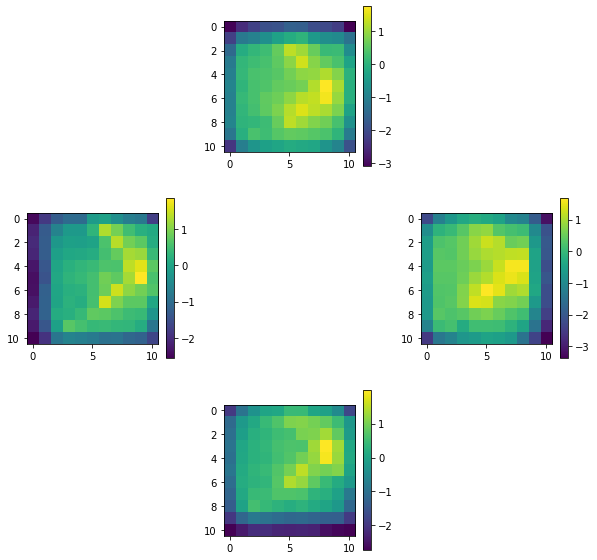

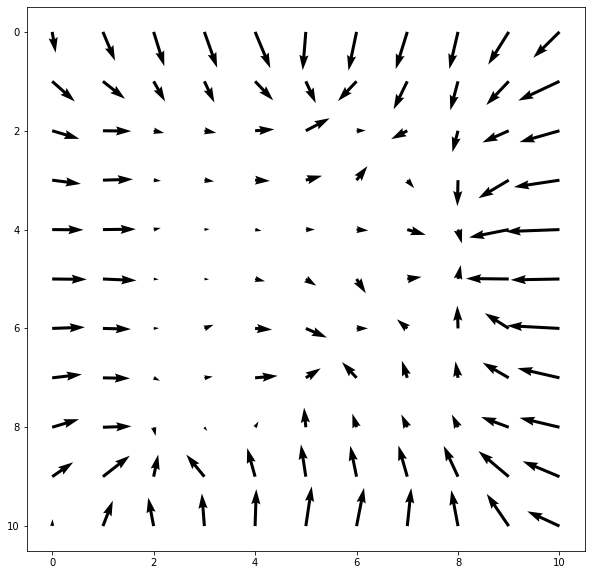

<Figure size 432x288 with 0 Axes>

In [ ]:
ie = 0

obs = envs[ie].observe()
vmap = np.zeros([11, 11])
vecmap = np.zeros([11, 11, 4])
for i in range(11):
    for j in range(11):
        obs[0, :,:,2] = 0
        obs[0,i,j, 2] = 1
        state = tr.tensor(obs).permute([0,3,1, 2]).float().cuda()
        sa.policy.eval()
        va = sa.policy(state)
        va = va.cpu().detach().numpy()
        vmap[i,j] = va[0, 0]#va.mean()
        vecmap[i,j] = va[0, 1:]

print(envs[ie]) # print the env[0]
plt.figure(figsize = [10, 10])
# plt.subplot(3,3,5)
# plt.imshow(vmap) # ?
#plt.clim([-1, 1]) # clim(): set the color range
# plt.colorbar()
lplt = [2, 8, 4, 6]
for i in range(4):
    plt.subplot(3,3,lplt[i]) # (3,3,2): 3 rows, 3 cols, and this plot is the 2nd plot
    plt.imshow(vecmap[:,:,i]) # 0, 1, 2, 3: moving up, moving down, moving left, moving right
    #plt.clim([-1, 1])
    plt.colorbar()
    # plt.clim([-2, -1])
    
# plt.savefig("valuemap.svg")

plt.figure(figsize = [10, 10])
vec = vecmap[:,:,[0,2]]-vecmap[:,:,[1,3]]
vec[:,:,1] = -vec[:,:,1]
# plt.quiver(x.flatten(),y.flatten(),vec[:,:,1].flatten(), vec[:,:,0].flatten(), scale = 10)
plt.quiver(vec[:,:,1], vec[:,:,0], scale = 30)
plt.gca().invert_yaxis()
plt.show()
# plt.clim([-2, 2])
# plt.colorbar()
# plt.savefig("policy.svg")
    
plt.savefig("valuemap.svg")